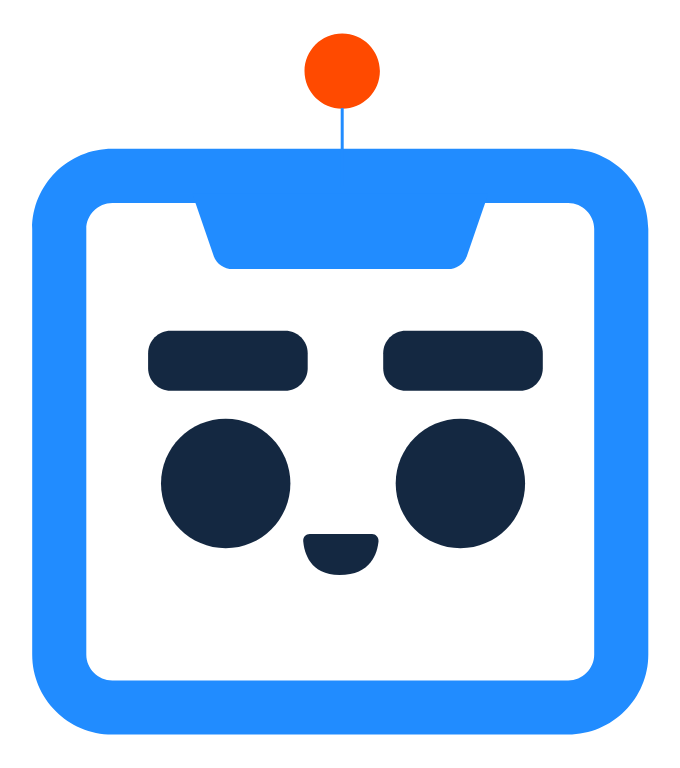

# Secure Ollama Access

This notebook provides a comprehensive guide to automating the secure login process for the Ollama platform using Selenium.

The Ollama Kubernetes deployment requires authenticated access via a secure OAuth2 proxy.

This notebook automates the login process, retrieves the necessary authentication cookie, and demonstrates how to use this cookie to interact with the Ollama API.

In [ ]:
# Install required libraries, restart the kernel after install

!pip install langchain_community selenium webdriver-manager

In [ ]:
# Import libraries
import logging

from langchain_community.llms import Ollama

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from webdriver_manager.chrome import ChromeDriverManager


# Set up logging for Jupyter notebook
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Check if handlers are already attached (to avoid adding multiple handlers)
if not logger.hasHandlers():
    # Create a console handler with a specific format
    console_handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    console_handler.setFormatter(formatter)
    
    # Add the handler to the logger
    logger.addHandler(console_handler)

In [ ]:
def get_kubert_oauth_cookie(kubert_ollama_url, kubert_cookie, wait_time=600):
    """
    Automates the login process to retrieve the '_kubert_oauth' cookie.

    Args:
        kubert_ollama_url (str): The URL to navigate to for logging in.
        kubert_cookie (str): The name of the secure cookie
        wait_time (int): Maximum time for the login to complete and the cookie to appear (in seconds).

    Returns:
        str: The cookie value.

    Raises:
        Exception: If the login fails or the cookie is not retrieved.
    """
    
    # Step 1: Set up Selenium and Chrome WebDriver
    chrome_options = Options()
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=chrome_options)

    try:
        # Step 2: Navigate to the login URL
        logging.info(f"Navigating to {kubert_ollama_url}...")
        driver.get(kubert_ollama_url)

        # Step 3: Wait until the "Ollama is running" text appears
        logging.info("Please complete the login process in the browser window...")
        try:
            WebDriverWait(driver, wait_time).until(  # Wait up to the specified wait_time
                lambda d: "Ollama is running" in d.page_source
            )
            logging.info("Login successful, 'Ollama is running' text found.")
        except TimeoutException:
            logging.error("Login timed out. 'Ollama is running' text not found.")
            raise Exception("Login process failed or took too long.")

        # Step 4: Capture cookies after login
        cookies = driver.get_cookies()

        # Find the specific cookie by name
        kubert_oauth_cookie = None
        for cookie in cookies:
            if cookie['name'] == cookie_name:
                kubert_oauth_cookie = cookie['value']
                break

        if kubert_oauth_cookie:
            logging.info("Kubert OAuth Cookie retrieved successfully.")
            return kubert_oauth_cookie
        else:
            logging.error("Failed to retrieve Kubert OAuth cookie.")
            raise Exception("Kubert OAuth cookie was not found after login.")

    finally:
        # Step 5: Close the browser window
        driver.quit()

### Test

1. Configure the Ollam URL to your Kubernetes ingress ULR.
2. Provide the secure cookie name that is configured with Oauth2 proxy deployed to process Ollama request.
3. Log into Keycloak with your account or provider.
4. Configure Ollama client and execute a test.

In [ ]:
# Ollama URL
ollama_url='add me'

# Name of the secure cookie
cookie_name = 'add me'

In [ ]:
# Initiate the login process and retrieve the cookie
cookie = get_kubert_oauth_cookie(ollama_url, cookie_name, wait_time=600)

# Headers for Ollama
ollama_headers = {
    "Cookie": f"{cookie_name}={cookie}"
}

In [ ]:
# Choose the Ollama model to use, assuming that it was pulled.
model="llama3.1:8b"

In [ ]:
# Create the Ollama client
ollama_kubert = Ollama(
    base_url=ollama_url,
    headers=ollama_headers,
    model=model
)

In [ ]:
# Quick test
response = ollama_kubert.invoke("What is Kubernetes?")
print(response)